# Brain Tumor Detection
## Single Task Validation - Building Bounding Box Regressor
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces/brain-tumor-detection'

In [2]:
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
tf.random.set_seed(42)

import matplotlib.pyplot as plt

2025-03-15 14:07:22.979993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742047642.987991  313340 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742047642.990595  313340 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742047642.999911  313340 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742047642.999922  313340 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742047642.999923  313340 computation_placer.cc:177] computation placer alr

In [3]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.19.0')

In [4]:
from src.data_handler.data_loader import DataLoader
from src.data_handler.annotation_processor import AnnotationProcessor
from src.data_handler.preprocessor import Preprocessor

In [5]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [6]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/-Brain-Tumor-Detection-2/train/


In [7]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [8]:
DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)


IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE
LOG_DIR = cfg.OUTPUTS.LOG_DIR
CHECK_POINT_DIR = Path(cfg.OUTPUTS.CHECKPOINT_PATH)
class_name_list = [
    'label0',
    'label1',
    'label2'
]
class_map = {k: v for k, v in enumerate(class_name_list)}

NUM_EPOCHS = cfg.TRAIN.NUM_EPOCHS
LEARNING_RATE = cfg.TRAIN.LEARNING_RATE

NUM_CLASSES = len(class_name_list)


## Dataset Download from Roboflow

In [9]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow(api_key="AAjLIN3PenSZ29LjbI3d")
    project = rf.workspace("yousef-ghanem-jzj4y").project("brain-tumor-detection-fpf1f")
    version = project.version(2)
    dataset = version.download("tensorflow")
                        

## Load images from directory

### Load Training datasets

In [10]:
prepare_train_dataset = AnnotationProcessor(annotation_file= str(TRAIN_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(class_name_list)}
train_images, train_class_ids, train_bboxes  = prepare_train_dataset.process_annotations(image_dir=TRAIN_DIR, class_id_map=_class_map)

len(train_images), len(train_class_ids), len(train_bboxes)

(6851, 6851, 6851)

In [11]:
train_class_ids

[[0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [0, 1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1, 2],
 [0, 1],
 [2],
 [1],
 [0, 1, 2],
 [1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1],
 [0, 1, 2],
 [1],
 [0, 1],
 [0, 1, 2],
 [1],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2]

In [12]:
train_images[0],train_class_ids[0], train_bboxes[0]

('datasets/-Brain-Tumor-Detection-2/train/volume_201_slice_92_jpg.rf.0012bdce7561c3808ed18953dc75060c.jpg',
 [0, 1, 2],
 array([[0.68345324, 0.54545455, 0.95683453, 0.76515152],
        [0.42446043, 0.48484848, 0.99280576, 0.96969697],
        [0.46043165, 0.53030303, 0.99280576, 0.78030303]]))

In [13]:
train_dl = DataLoader(train_images, train_class_ids, train_bboxes)
train_ds = train_dl.load_train_dataset()
train_ds = Preprocessor(train_ds).preprocess()
train_ds = train_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

I0000 00:00:1742047655.922441  313340 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7183 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [14]:
for batch in train_ds.take(1):
    image, bbx = batch
    print(image.shape, bbx.shape)
    print(bbx[5])
    print(image[1].numpy().min(), image[1].numpy().max())


(32, 240, 240, 3) (32, 3, 4)
tf.Tensor(
[[0.676259   0.8484849  0.78417265 0.90909094]
 [0.52517986 0.65909094 0.8489209  0.9621212 ]
 [0.6618705  0.8030303  0.8057554  0.95454544]], shape=(3, 4), dtype=float32)
-100.03017 151.061


2025-03-15 14:07:41.109093: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Validation datasets 

In [15]:
prepare_valid_dataset = AnnotationProcessor(annotation_file= str(VALIDATION_DIR/'_annotations.csv'))
valid_image_paths, valid_class_ids, valid_bboxes  = prepare_valid_dataset.process_annotations(image_dir=VALIDATION_DIR, class_id_map=_class_map)
len(valid_image_paths), len(valid_class_ids), len(valid_bboxes)

(1963, 1963, 1963)

In [16]:
valid_dl = DataLoader(valid_image_paths, valid_class_ids, valid_bboxes).load_val_dataset()
valid_ds = Preprocessor(valid_dl).preprocess()
valid_ds = valid_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

In [17]:
for batch in valid_ds.take(1):
    image, bbx, = batch
    print(bbx.shape)
    print(image.shape)
    print(image[1].numpy().min(), image[1].numpy().max())

(32, 3, 4)
(32, 240, 240, 3)
-123.68 138.49847


2025-03-15 14:07:42.442320: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training Setup

In [18]:
from src.losses import iou_loss
REG_METRICS = [
    iou_loss.iou_metric,
    tf.keras.metrics.MeanSquaredError(name='mse'),
    tf.keras.metrics.MeanAbsoluteError(name='mae'),
]

### Define  Callbacks

In [19]:
import os

to_monitor = 'val_iou_metric'
mode = 'max'
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, 
                                            patience=5, 
                                            monitor=to_monitor,
                                            mode=mode,
                                            min_lr=1e-8,
                                            verbose=1),
            tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(str(CHECK_POINT_DIR), "reg_ckpt_{epoch}.keras") ,
                                            save_weights_only=False,
                                            save_best_only=True,
                                            monitor=to_monitor,
                                            mode=mode,
                                            verbose=1),
            tf.keras.callbacks.EarlyStopping(monitor=to_monitor, 
                                            patience=10,
                                            mode=mode, 
                                            restore_best_weights=True,
                                            verbose=1)]

### Define Optimizer

In [20]:
optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE)

## Define ResNet50 Model Classifier

In [ ]:
from src.models.resnet101 import resnet101_regressor
import mlflow
tf.keras.backend.clear_session()

mlflow.set_experiment("/brain-tumor-resnet101_regressor-IoU-loss")
mlflow.tensorflow.autolog(log_models=True, 
                          log_datasets=False, 
                          log_input_examples=True,
                          keras_model_kwargs={"save_format": "keras"},
                          checkpoint_monitor=to_monitor, 
                          checkpoint_mode=mode)

model = resnet101_regressor(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=NUM_CLASSES)

model.summary()

2025/03/15 14:07:44 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.18.0, but the installed version is 2.19.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.


Total layers in ResNet101: 345
Unfreezing the last 172 layers (50% of total layers)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 246, 246,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 120, 120,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 120, 120,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 120, 120,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 122, 122,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 60, 60,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 60, 60,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 60, 60,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 60, 60,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 60, 60,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 60, 60,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 60, 60,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 60, 60,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 60, 60,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 60, 60,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 60, 60,    │      1,024 │ conv2_block1_3_c

 Total params: 44,768,652 (170.78 MB)

 Trainable params: 32,748,556 (124.93 MB)

 Non-trainable params: 12,020,096 (45.85 MB)

## Model Building and Compilation

In [22]:
from src.losses import iou_loss
model.compile(
    optimizer=optimizer,
    loss=iou_loss.iou_loss,
    metrics=REG_METRICS)  

## Train and Validate the model

In [23]:
history = model.fit(train_ds,
    epochs=NUM_EPOCHS,
    validation_data=valid_ds,
    batch_size=BATCH_SIZE,
    callbacks=[callbacks])

2025/03/15 14:07:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd78754cb55f34b0a9c74ea762035944e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/30


I0000 00:00:1742047691.579239  313612 service.cc:152] XLA service 0x770fac002420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742047691.579281  313612 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-15 14:08:12.283076: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742047695.587754  313612 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/215 ━━━━━━━━━━━━━━━━━━━━ 2:14:53 38s/step - iou_metric: 0.0314 - loss: 0.9686 - mae: 0.3000 - mse: 0.1338

I0000 00:00:1742047705.035908  313612 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - iou_metric: 0.1546 - loss: 0.8458 - mae: 0.2923 - mse: 0.1514
Epoch 1: val_iou_metric improved from -inf to 0.34716, saving model to output/checkpoints/reg_ckpt_1.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 85s 223ms/step - iou_metric: 0.1549 - loss: 0.8456 - mae: 0.2922 - mse: 0.1513 - val_iou_metric: 0.3472 - val_loss: 0.6533 - val_mae: 0.2088 - val_mse: 0.0987 - learning_rate: 1.0000e-04
Epoch 2/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - iou_metric: 0.3205 - loss: 0.6800 - mae: 0.2315 - mse: 0.1193
Epoch 2: val_iou_metric improved from 0.34716 to 0.40169, saving model to output/checkpoints/reg_ckpt_2.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - iou_metric: 0.3207 - loss: 0.6799 - mae: 0.2315 - mse: 0.1192 - val_iou_metric: 0.4017 - val_loss: 0.5990 - val_mae: 0.2076 - val_mse: 0.1080 - learning_rate: 1.0000e-04
Epoch 3/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - iou_metric: 0.3744 - loss: 0.6260 - mae: 0.2109 - mse: 0.1078
Epoch 3: val_iou_metric did not improve from 0.40169
215/215 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - iou_metric: 0.3744 - loss: 0.6261 - mae: 0.2109 - mse: 0.1078 - val_iou_metric: 0.3878 - val_loss: 0.6125 - val_mae: 0.1923 - val_mse: 0.0920 - learning_rate: 1.0000e-04
Epoch 4/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - iou_metric: 0.3846 - loss: 0.6162 - mae: 0.2131 - mse: 0.1118
Epoch 4: val_iou_metric improved from 0.40169 to 0.41337, saving model to output/checkpoints/reg_ckpt_4.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - iou_metric: 0.3847 - loss: 0.6161 - mae: 0.2131 - mse: 0.1118 - val_iou_metric: 0.4134 - val_loss: 0.5872 - val_mae: 0.1962 - val_mse: 0.1003 - learning_rate: 1.0000e-04
Epoch 5/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - iou_metric: 0.4085 - loss: 0.5925 - mae: 0.2073 - mse: 0.1088
Epoch 5: val_iou_metric improved from 0.41337 to 0.41687, saving model to output/checkpoints/reg_ckpt_5.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - iou_metric: 0.4086 - loss: 0.5924 - mae: 0.2073 - mse: 0.1088 - val_iou_metric: 0.4169 - val_loss: 0.5837 - val_mae: 0.1939 - val_mse: 0.0976 - learning_rate: 1.0000e-04
Epoch 6/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - iou_metric: 0.4210 - loss: 0.5796 - mae: 0.2040 - mse: 0.1076
Epoch 6: val_iou_metric improved from 0.41687 to 0.48014, saving model to output/checkpoints/reg_ckpt_6.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - iou_metric: 0.4211 - loss: 0.5795 - mae: 0.2040 - mse: 0.1076 - val_iou_metric: 0.4801 - val_loss: 0.5205 - val_mae: 0.1808 - val_mse: 0.0908 - learning_rate: 1.0000e-04
Epoch 7/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - iou_metric: 0.4346 - loss: 0.5659 - mae: 0.2046 - mse: 0.1093
Epoch 7: val_iou_metric improved from 0.48014 to 0.48172, saving model to output/checkpoints/reg_ckpt_7.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 132ms/step - iou_metric: 0.4346 - loss: 0.5659 - mae: 0.2046 - mse: 0.1093 - val_iou_metric: 0.4817 - val_loss: 0.5190 - val_mae: 0.1811 - val_mse: 0.0916 - learning_rate: 1.0000e-04
Epoch 8/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - iou_metric: 0.4422 - loss: 0.5584 - mae: 0.2019 - mse: 0.1063
Epoch 8: val_iou_metric did not improve from 0.48172
215/215 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - iou_metric: 0.4422 - loss: 0.5584 - mae: 0.2018 - mse: 0.1063 - val_iou_metric: 0.4806 - val_loss: 0.5200 - val_mae: 0.1758 - val_mse: 0.0861 - learning_rate: 1.0000e-04
Epoch 9/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - iou_metric: 0.4508 - loss: 0.5497 - mae: 0.1945 - mse: 0.1010
Epoch 9: val_iou_metric improved from 0.48172 to 0.49552, saving model to output/checkpoints/reg_ckpt_9.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - iou_metric: 0.4508 - loss: 0.5497 - mae: 0.1945 - mse: 0.1010 - val_iou_metric: 0.4955 - val_loss: 0.5052 - val_mae: 0.1835 - val_mse: 0.0963 - learning_rate: 1.0000e-04
Epoch 10/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - iou_metric: 0.4725 - loss: 0.5284 - mae: 0.1904 - mse: 0.0997
Epoch 10: val_iou_metric improved from 0.49552 to 0.49834, saving model to output/checkpoints/reg_ckpt_10.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - iou_metric: 0.4725 - loss: 0.5284 - mae: 0.1904 - mse: 0.0997 - val_iou_metric: 0.4983 - val_loss: 0.5024 - val_mae: 0.1871 - val_mse: 0.1009 - learning_rate: 1.0000e-04
Epoch 11/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - iou_metric: 0.4769 - loss: 0.5236 - mae: 0.1912 - mse: 0.1013
Epoch 11: val_iou_metric did not improve from 0.49834
215/215 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - iou_metric: 0.4769 - loss: 0.5236 - mae: 0.1912 - mse: 0.1013 - val_iou_metric: 0.4889 - val_loss: 0.5118 - val_mae: 0.1806 - val_mse: 0.0911 - learning_rate: 1.0000e-04
Epoch 12/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - iou_metric: 0.4774 - loss: 0.5234 - mae: 0.1905 - mse: 0.1006
Epoch 12: val_iou_metric improved from 0.49834 to 0.51651, saving model to output/checkpoints/reg_ckpt_12.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - iou_metric: 0.4774 - loss: 0.5234 - mae: 0.1905 - mse: 0.1006 - val_iou_metric: 0.5165 - val_loss: 0.4842 - val_mae: 0.1769 - val_mse: 0.0945 - learning_rate: 1.0000e-04
Epoch 13/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - iou_metric: 0.5003 - loss: 0.4999 - mae: 0.1853 - mse: 0.0984
Epoch 13: val_iou_metric did not improve from 0.51651
215/215 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - iou_metric: 0.5003 - loss: 0.4999 - mae: 0.1853 - mse: 0.0984 - val_iou_metric: 0.5069 - val_loss: 0.4940 - val_mae: 0.1731 - val_mse: 0.0887 - learning_rate: 1.0000e-04
Epoch 14/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - iou_metric: 0.4997 - loss: 0.5006 - mae: 0.1940 - mse: 0.1061
Epoch 14: val_iou_metric improved from 0.51651 to 0.51655, saving model to output/checkpoints/reg_ckpt_14.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - iou_metric: 0.4997 - loss: 0.5006 - mae: 0.1939 - mse: 0.1060 - val_iou_metric: 0.5165 - val_loss: 0.4843 - val_mae: 0.1781 - val_mse: 0.0931 - learning_rate: 1.0000e-04
Epoch 15/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - iou_metric: 0.5055 - loss: 0.4949 - mae: 0.1833 - mse: 0.0983
Epoch 15: val_iou_metric improved from 0.51655 to 0.51731, saving model to output/checkpoints/reg_ckpt_15.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - iou_metric: 0.5055 - loss: 0.4949 - mae: 0.1833 - mse: 0.0983 - val_iou_metric: 0.5173 - val_loss: 0.4835 - val_mae: 0.1740 - val_mse: 0.0893 - learning_rate: 1.0000e-04
Epoch 16/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - iou_metric: 0.5074 - loss: 0.4935 - mae: 0.1884 - mse: 0.1017
Epoch 16: val_iou_metric improved from 0.51731 to 0.52360, saving model to output/checkpoints/reg_ckpt_16.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - iou_metric: 0.5074 - loss: 0.4935 - mae: 0.1884 - mse: 0.1017 - val_iou_metric: 0.5236 - val_loss: 0.4770 - val_mae: 0.1727 - val_mse: 0.0875 - learning_rate: 1.0000e-04
Epoch 17/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - iou_metric: 0.5144 - loss: 0.4862 - mae: 0.1840 - mse: 0.0983
Epoch 17: val_iou_metric did not improve from 0.52360
215/215 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - iou_metric: 0.5144 - loss: 0.4862 - mae: 0.1840 - mse: 0.0983 - val_iou_metric: 0.5112 - val_loss: 0.4895 - val_mae: 0.1794 - val_mse: 0.0975 - learning_rate: 1.0000e-04
Epoch 18/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - iou_metric: 0.5207 - loss: 0.4802 - mae: 0.1811 - mse: 0.0967
Epoch 18: val_iou_metric improved from 0.52360 to 0.52509, saving model to output/checkpoints/reg_ckpt_18.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - iou_metric: 0.5207 - loss: 0.4802 - mae: 0.1811 - mse: 0.0968 - val_iou_metric: 0.5251 - val_loss: 0.4759 - val_mae: 0.1812 - val_mse: 0.0993 - learning_rate: 1.0000e-04
Epoch 19/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - iou_metric: 0.5271 - loss: 0.4736 - mae: 0.1812 - mse: 0.0980
Epoch 19: val_iou_metric improved from 0.52509 to 0.52893, saving model to output/checkpoints/reg_ckpt_19.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - iou_metric: 0.5271 - loss: 0.4736 - mae: 0.1813 - mse: 0.0981 - val_iou_metric: 0.5289 - val_loss: 0.4717 - val_mae: 0.1728 - val_mse: 0.0903 - learning_rate: 1.0000e-04
Epoch 20/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - iou_metric: 0.5286 - loss: 0.4723 - mae: 0.1813 - mse: 0.0978
Epoch 20: val_iou_metric did not improve from 0.52893
215/215 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - iou_metric: 0.5286 - loss: 0.4722 - mae: 0.1813 - mse: 0.0978 - val_iou_metric: 0.5272 - val_loss: 0.4735 - val_mae: 0.1761 - val_mse: 0.0944 - learning_rate: 1.0000e-04
Epoch 21/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - iou_metric: 0.5322 - loss: 0.4687 - mae: 0.1811 - mse: 0.0981
Epoch 21: val_iou_metric did not improve from 0.52893
215/215 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - iou_metric: 0.5322 - loss: 0.4687 - mae: 0.1812 - mse: 0.0981 - val_iou_metric: 0.5207 - val_loss: 0.4802 - val_mae: 0.1713 - val_mse: 0.0880 - learning_rate: 1.0000e-04
Epoch 

215/215 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - iou_metric: 0.5330 - loss: 0.4678 - mae: 0.1823 - mse: 0.0987 - val_iou_metric: 0.5380 - val_loss: 0.4628 - val_mae: 0.1730 - val_mse: 0.0923 - learning_rate: 1.0000e-04
Epoch 23/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - iou_metric: 0.5451 - loss: 0.4557 - mae: 0.1835 - mse: 0.1024
Epoch 23: val_iou_metric did not improve from 0.53795
215/215 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - iou_metric: 0.5451 - loss: 0.4557 - mae: 0.1835 - mse: 0.1024 - val_iou_metric: 0.5359 - val_loss: 0.4646 - val_mae: 0.1700 - val_mse: 0.0867 - learning_rate: 1.0000e-04
Epoch 24/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - iou_metric: 0.5536 - loss: 0.4472 - mae: 0.1788 - mse: 0.0975
Epoch 24: val_iou_metric improved from 0.53795 to 0.54266, saving model to output/checkpoints/reg_ckpt_24.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - iou_metric: 0.5535 - loss: 0.4472 - mae: 0.1788 - mse: 0.0975 - val_iou_metric: 0.5427 - val_loss: 0.4581 - val_mae: 0.1749 - val_mse: 0.0953 - learning_rate: 1.0000e-04
Epoch 25/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - iou_metric: 0.5520 - loss: 0.4485 - mae: 0.1757 - mse: 0.0948
Epoch 25: val_iou_metric improved from 0.54266 to 0.54981, saving model to output/checkpoints/reg_ckpt_25.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 32s 132ms/step - iou_metric: 0.5520 - loss: 0.4485 - mae: 0.1757 - mse: 0.0949 - val_iou_metric: 0.5498 - val_loss: 0.4508 - val_mae: 0.1701 - val_mse: 0.0882 - learning_rate: 1.0000e-04
Epoch 26/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - iou_metric: 0.5577 - loss: 0.4427 - mae: 0.1787 - mse: 0.0985
Epoch 26: val_iou_metric did not improve from 0.54981
215/215 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - iou_metric: 0.5577 - loss: 0.4427 - mae: 0.1787 - mse: 0.0985 - val_iou_metric: 0.5471 - val_loss: 0.4535 - val_mae: 0.1753 - val_mse: 0.0948 - learning_rate: 1.0000e-04
Epoch 27/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - iou_metric: 0.5628 - loss: 0.4377 - mae: 0.1769 - mse: 0.0970
Epoch 27: val_iou_metric improved from 0.54981 to 0.55100, saving model to output/checkpoints/reg_ckpt_27.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 32s 131ms/step - iou_metric: 0.5628 - loss: 0.4377 - mae: 0.1769 - mse: 0.0970 - val_iou_metric: 0.5510 - val_loss: 0.4496 - val_mae: 0.1684 - val_mse: 0.0862 - learning_rate: 1.0000e-04
Epoch 28/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - iou_metric: 0.5642 - loss: 0.4367 - mae: 0.1786 - mse: 0.0987
Epoch 28: val_iou_metric improved from 0.55100 to 0.55139, saving model to output/checkpoints/reg_ckpt_28.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 32s 130ms/step - iou_metric: 0.5641 - loss: 0.4367 - mae: 0.1786 - mse: 0.0987 - val_iou_metric: 0.5514 - val_loss: 0.4493 - val_mae: 0.1741 - val_mse: 0.0928 - learning_rate: 1.0000e-04
Epoch 29/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - iou_metric: 0.5580 - loss: 0.4421 - mae: 0.1835 - mse: 0.1019
Epoch 29: val_iou_metric did not improve from 0.55139
215/215 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - iou_metric: 0.5581 - loss: 0.4421 - mae: 0.1835 - mse: 0.1018 - val_iou_metric: 0.5502 - val_loss: 0.4504 - val_mae: 0.1636 - val_mse: 0.0809 - learning_rate: 1.0000e-04
Epoch 30/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - iou_metric: 0.5640 - loss: 0.4369 - mae: 0.1754 - mse: 0.0947
Epoch 30: val_iou_metric did not improve from 0.55139
215/215 ━━━━━━━━━━━━━━━━━━━━ 29s 117ms/step - iou_metric: 0.5640 - loss: 0.4369 - mae: 0.1754 - mse: 0.0947 - val_iou_metric: 0.5488 - val_loss: 0.4520 - val_mae: 0.1804 - val_mse: 0.1009 - learning_rate: 1.0000e-04
Restor

2025/03/15 14:25:03 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpk5p_jrdz/model, flavor: tensorflow). Fall back to return ['tensorflow==2.19.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/15 14:25:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


## Training Visualization

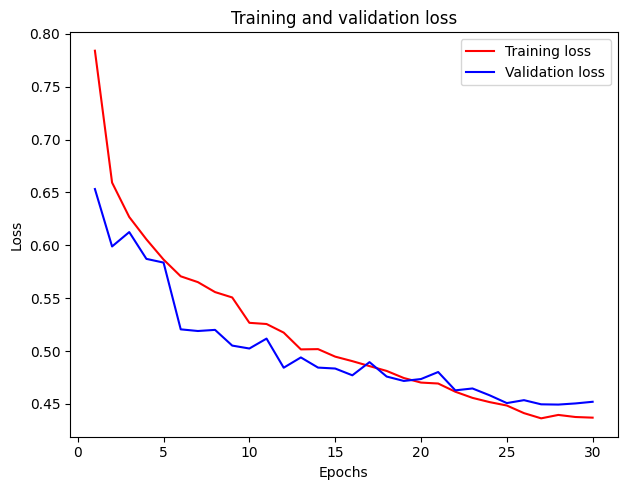

In [24]:
from src.utils.visualization_funcs import visualize_training_results

visualize_training_results(history.history)

## Model Evaluation

### Testing Datasets setup

In [25]:
prepare_test_dataset = AnnotationProcessor(annotation_file= str(TEST_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(class_name_list)}
test_image_paths, test_class_ids, test_bboxes = prepare_test_dataset.process_annotations(image_dir=TEST_DIR, class_id_map=_class_map)

len(test_image_paths), len(test_class_ids), len(test_bboxes)

(973, 973, 973)

In [26]:
test_dl = DataLoader(test_image_paths, test_class_ids, test_bboxes, img_size=IMG_SIZE)
test_ds = test_dl.load_val_dataset()
y_true = test_dl.padded_bbx
test_ds = Preprocessor(test_ds).preprocess()
test_ds = test_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

In [27]:
results = model.evaluate(test_ds,return_dict=True)
mlflow.log_metrics(results)
print("Testing accuracy: ", results)

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - iou_metric: 0.5492 - loss: 0.4514 - mae: 0.1898 - mse: 0.1048
Testing accuracy:  {'iou_metric': 0.5537571310997009, 'loss': 0.44657790660858154, 'mae': 0.1850888878107071, 'mse': 0.10089167207479477}


In [28]:
pred_bbx = model.predict(test_ds)
pred_bbx[:5]

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step


array([[[0.5785896 , 0.65471005, 0.7605548 , 0.82113713],
        [0.3302217 , 0.57546234, 0.87640595, 0.93844354],
        [0.55257595, 0.6384119 , 0.7776695 , 0.84889835]],

       [[0.6208144 , 0.09309238, 0.97129726, 0.46267584],
        [0.6366716 , 0.09770011, 0.9831515 , 0.46563148],
        [0.6938916 , 0.12897275, 0.96497667, 0.41576937]],

       [[0.2670844 , 0.59202653, 0.69061756, 0.8686551 ],
        [0.21810459, 0.50404716, 0.8470846 , 0.9437468 ],
        [0.2866783 , 0.59796935, 0.673522  , 0.8520168 ]],

       [[0.5467575 , 0.04351074, 0.8549264 , 0.37135574],
        [0.520825  , 0.03036585, 0.90939146, 0.3765951 ],
        [0.53922766, 0.042531  , 0.8666981 , 0.37056288]],

       [[0.23291914, 0.5727705 , 0.6180103 , 0.8638748 ],
        [0.21165028, 0.520981  , 0.72940505, 0.899749  ],
        [0.24303661, 0.583482  , 0.61023617, 0.85407776]]], dtype=float32)

In [29]:
from src.losses.iou_loss import iou_metric

iou_metric(y_true[0], pred_bbx[0])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.75337225, 0.786232  , 0.6743129 ], dtype=float32)>

In [30]:
def plot_iou_histogram(y_true_bbox, y_pred_bbox, class_ids):
    """
    Plots a histogram of Intersection over Union (IoU) scores.

    Args:
        y_true_bbox: Ground truth bounding boxes (list of lists or numpy array).
        y_pred_bbox: Predicted bounding boxes (list of lists or numpy array).
        class_ids: list of class ids.
    """
    fig, axs = plt.subplots(1)

    iou_scores = iou_metric(y_true_bbox, y_pred_bbox)

    # fig.figure(figsize=(10, 6))
    axs.hist(iou_scores, bins=20, range=(0, 1), edgecolor='black')
    axs.set_title('IoU Score Distribution')
    axs.set_xlabel('IoU Score')
    axs.set_ylabel('Frequency')
    axs.grid(True)
    plt.show()
    plt.savefig(f"{cfg.OUTPUTS.OUPUT_DIR}/iou_histogram.png")
    return fig


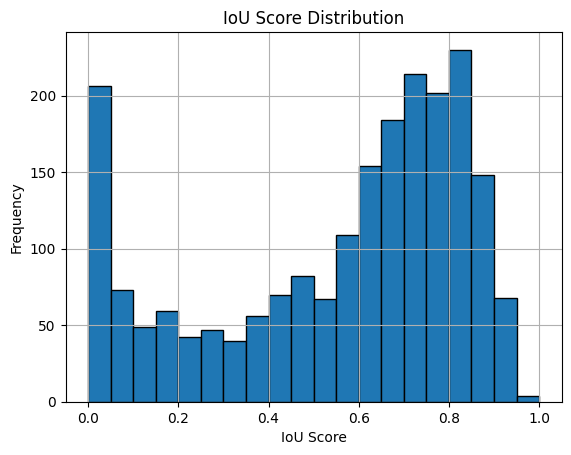

<Figure size 640x480 with 0 Axes>

In [31]:
fig = plot_iou_histogram(y_true, pred_bbx, pred_bbx)
mlflow.log_figure(fig, 'iou_histogram.png')